In [ ]:
%pip install sentence_transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
import pandas as pd
import requests
from io import BytesIO
import gzip,shutil
import os
import numpy as np


In [3]:
# URLs of IMDb datasets
dataset_urls = {
    'title.basics': 'https://datasets.imdbws.com/title.basics.tsv.gz',
    'title.crew': 'https://datasets.imdbws.com/title.crew.tsv.gz',
    'title.episode': 'https://datasets.imdbws.com/title.episode.tsv.gz',
    'title.ratings': 'https://datasets.imdbws.com/title.ratings.tsv.gz',
    'name.basics': 'https://datasets.imdbws.com/name.basics.tsv.gz'
}

def download_and_extract(url, output_path):
    response = requests.get(url, stream=True)
    with open(output_path, 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    with gzip.open(output_path, 'rb') as f_in:
        with open(output_path.replace('.gz', ''), 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    os.remove(output_path)  # Remove the compressed file

for name, url in dataset_urls.items():
    download_and_extract(url, f'{name}.tsv.gz')

In [4]:
name_basics = pd.read_csv("name.basics.tsv", sep ="\t")


In [5]:
name_basics.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0072308,tt0050419,tt0027125,tt0025164"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack,archive_footage","tt0037382,tt0075213,tt0038355,tt0117057"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,music_department,producer","tt0057345,tt0049189,tt0056404,tt0054452"
3,nm0000004,John Belushi,1949,1982,"actor,writer,music_department","tt0072562,tt0077975,tt0080455,tt0078723"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0069467,tt0050976,tt0083922"


In [6]:
name_basics.drop(columns=["knownForTitles","primaryProfession","birthYear","deathYear"],inplace= True)

In [7]:
title_basics = pd.read_csv("title.basics.tsv", sep ="\t")

/var/tmp/ipykernel_7967/295181411.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  title_basics = pd.read_csv("title.basics.tsv", sep ="\t")


In [8]:
title_basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Poor Pierrot,Pauvre Pierrot,0,1892,\N,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,Short


In [9]:
title_basics.drop(columns=["primaryTitle","endYear","isAdult"],inplace=True)


In [10]:
title_crew = pd.read_csv("title.crew.tsv", sep = "\t")


In [11]:
title_crew.head()

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,nm0721526
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N


In [12]:
title_crew.drop(columns=["writers"],inplace=True)

In [13]:
title_ratings = pd.read_csv("title.ratings.tsv", sep ="\t")


In [14]:
title_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2165
1,tt0000002,5.5,296
2,tt0000003,6.5,2224
3,tt0000004,5.3,190
4,tt0000005,6.2,2963


In [15]:
title_episode = pd.read_csv("title.episode.tsv",usecols=["tconst"],sep="\t")

In [16]:
exclude_idx=title_episode["tconst"].values

In [17]:
# Merge the datasets
merged_df = title_basics.merge(title_crew, on='tconst', how='left') \
                      .merge(title_ratings, on='tconst', how='left')


In [18]:
merged_df.rename(columns={'directors':'nconst'},inplace=True)

In [19]:
merged_df = merged_df[~merged_df['tconst'].isin(exclude_idx)]


In [20]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2717727 entries, 0 to 11798576
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   tconst          object 
 1   titleType       object 
 2   originalTitle   object 
 3   startYear       object 
 4   runtimeMinutes  object 
 5   genres          object 
 6   nconst          object 
 7   averageRating   float64
 8   numVotes        float64
dtypes: float64(2), object(7)
memory usage: 207.3+ MB


In [21]:
merged_df = merged_df.merge(name_basics,on="nconst",how="left")

In [22]:
merged_df.drop(columns=["nconst"],inplace=True)


In [23]:
merged_df.titleType.unique()

array(['short', 'movie', 'tvShort', 'tvMovie', 'tvSeries', 'tvMiniSeries',
       'tvSpecial', 'video', 'videoGame', 'tvPilot', 'tvEpisode'],
      dtype=object)

In [24]:
merged_df = merged_df.query('titleType=="movie" or titleType =="tvSeries" or titleType == "tvMovie"')

### Del df to save memory

In [25]:
del name_basics
del title_basics
del title_crew
del title_episode
del title_ratings

## MovieLens Data

In [26]:
import requests
import zipfile
import os

def download_and_extract_zip(url, output_path):
    # Step 1: Download the ZIP file
    try:
        print(f"Downloading from {url}...")
        response = requests.get(url)
        response.raise_for_status()  # Will raise an exception for bad responses
        zip_path = 'temp.zip'  # Temporary path for the downloaded file
        
        with open(zip_path, 'wb') as f:
            f.write(response.content)
        
        print(f"Downloaded ZIP to {zip_path}.")
        
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
        return

    # Step 2: Extract the ZIP file
    try:
        print(f"Extracting {zip_path} to {output_path}...")
        
        # Create the output_path  if it doesn't exist
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(output_path)
                
    except zipfile.BadZipFile:
        print(f"Error: {zip_path} is not a valid ZIP file.")
    except Exception as e:
        print(f"Error extracting the ZIP file: {e}")
    
    # Clean up the temporary zip file
    os.remove(zip_path)
    print("Temporary ZIP file removed.")

# Example usage:
url = "https://files.grouplens.org/datasets/movielens/ml-32m.zip"  # Replace with your actual URL
output_path = "./"  # Folder where you want to extract the contents

download_and_extract_zip(url, output_path)


Downloaded ZIP to temp.zip.
Extracting temp.zip to ./...
Temporary ZIP file removed.


In [27]:
rates = pd.read_csv("ml-32m/ratings.csv")

In [28]:
rates.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [29]:
rates

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858
...,...,...,...,...
32000199,200948,79702,4.5,1294412589
32000200,200948,79796,1.0,1287216292
32000201,200948,80350,0.5,1294412671
32000202,200948,80463,3.5,1350423800


In [30]:
rates=rates.groupby("movieId")["rating"].mean().to_frame()

In [31]:
tags = pd.read_csv("ml-32m/tags.csv")

In [32]:
tags["tag"] = tags["tag"].astype("str")

In [33]:
tags = tags.groupby('movieId')['tag'].apply(lambda x: ', '.join(x.value_counts().head(10).index)).to_frame()

In [34]:
mv_data = rates.merge(tags , left_index = True, right_index = True, how ="left")

In [35]:
mv_data.head()

,rating,tag
movieId,,
1,3.897438,"Pixar, animation, Disney, funny, Tom Hanks, pi..."
2,3.275758,"Robin Williams, fantasy, time travel, board ga..."
3,3.139447,"comedinha de velhinhos engraÃƒÂ§ada, comedinha..."
4,2.845331,"chick flick, characters, slurs, based on novel..."
5,3.059602,"pregnancy, Steve Martin, family, daughter, Dia..."


In [36]:
links = pd.read_csv("ml-32m/links.csv", usecols=["movieId", "imdbId"], dtype={"imdbId": str})


In [37]:
mv_data = mv_data.merge(links, left_index=True, right_on="movieId", how = "left")

In [38]:
mv_data.drop(columns=["movieId"],inplace=True)

In [39]:
mv_data["imdbId"] = "tt" + mv_data["imdbId"].astype(str)

In [40]:
mv_data.rename(columns={"rating":"movielens_rating","imdbId":"tconst"},inplace = True)

In [41]:
merged_df = merged_df.merge(mv_data,on="tconst",how="left")

In [42]:
merged_df.titleType.unique()

array(['movie', 'tvMovie', 'tvSeries'], dtype=object)

## EXTERNAL KAGGLE DATA

In [43]:
!pip install kagglehub

In [44]:
!export KAGGLEHUB_CACHE= 


In [45]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alanvourch/tmdb-movies-daily-updates")

print("Path to dataset files:", path)

100%|██████████| 272M/272M [00:02<00:00, 124MB/s]  

Extracting files...


Path to dataset files: /home/jupyter/.cache/kagglehub/datasets/alanvourch/tmdb-movies-daily-updates/versions/566


In [46]:
filename = "TMDB_all_movies.csv"
file_path = os.path.join(path,filename)

In [47]:
kaggle_df = pd.read_csv(file_path, usecols=["imdb_id", "overview", "imdb_rating", "imdb_votes"])
kaggle_df = kaggle_df[kaggle_df['imdb_id'].notna()]

In [48]:
cn = ["tconst", "overview", "averageRating", "numVotes" ]
kaggle_df.columns = cn 

In [49]:
kaggle_df.head()

,tconst,overview,averageRating,numVotes
0,tt0094675,A Finnish man goes to the city to find a job a...,7.4,9288.0
1,tt0092149,"Nikander, a rubbish collector and would-be ent...",7.4,8116.0
2,tt0113101,It's Ted the Bellhop's first night on the job....,6.7,114700.0
3,tt0107286,"Four young friends, while taking a shortcut en...",6.6,20163.0
4,tt0825671,Timo Novotny labels his new project an experim...,8.1,285.0


In [50]:
merged_df.drop(columns = ["averageRating","numVotes"],inplace=True)

In [51]:
merged_df.head()

,tconst,titleType,originalTitle,startYear,runtimeMinutes,genres,primaryName,movielens_rating,tag
0,tt0000009,movie,Miss Jerry,1894,45,Romance,Alexander Black,NaN,NaN
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,1897,100,"Documentary,News,Sport",Enoch J. Rector,NaN,NaN
2,tt0000502,movie,Bohemios,1905,100,\N,Ricardo de Baños,NaN,NaN
3,tt0000574,movie,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography",Charles Tait,2.5,"partially lost film, silent film"
4,tt0000591,movie,L'enfant prodigue,1907,90,Drama,Michel Carré,NaN,NaN


In [52]:
merged_df = merged_df.merge(kaggle_df, on="tconst", how="left")

### Data Visualization

In [53]:
import seaborn as sns

<Axes: xlabel='averageRating', ylabel='numVotes'>

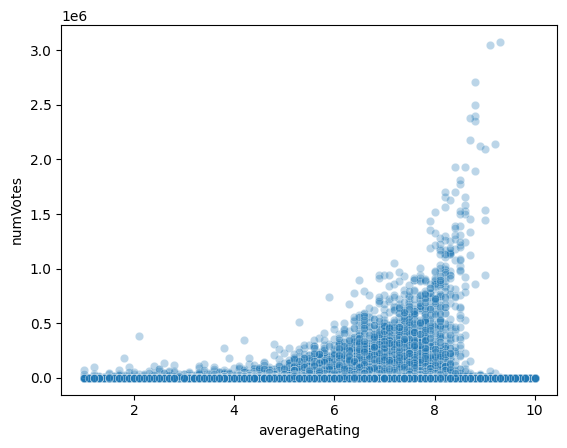

In [54]:
sns.scatterplot(merged_df,x="averageRating",y="numVotes",alpha = 0.3)

In [55]:
import chromadb.utils.embedding_functions as embedding_functions


In [56]:
merged_df.rename(columns={'primaryName':'director'},inplace=True)

In [58]:
merged_df.head()

,tconst,titleType,originalTitle,startYear,runtimeMinutes,genres,director,movielens_rating,tag,overview,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,1894,45,Romance,Alexander Black,NaN,NaN,The adventures of a female reporter in the 1890s.,5.4,227.0
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,1897,100,"Documentary,News,Sport",Enoch J. Rector,NaN,NaN,"This legendary fight was filmed on March 17, 1...",5.3,563.0
2,tt0000502,movie,Bohemios,1905,100,\N,Ricardo de Baños,NaN,NaN,NaN,NaN,NaN
3,tt0000574,movie,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography",Charles Tait,2.5,"partially lost film, silent film",Just as Galeen and Wegener's Der Golem (1915) ...,6.0,1005.0
4,tt0000591,movie,L'enfant prodigue,1907,90,Drama,Michel Carré,NaN,NaN,The first feature-length motion picture produc...,5.4,33.0


In [79]:
merged_df.dropna(subset=['tag', 'overview'],how ="all",inplace=True)


In [81]:
merged_df.head()

,tconst,titleType,originalTitle,startYear,runtimeMinutes,genres,director,movielens_rating,tag,overview,averageRating,numVotes
0,tt0000009,movie,Miss Jerry,1894,45,Romance,Alexander Black,NaN,NaN,The adventures of a female reporter in the 1890s.,5.4,227.0
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,1897,100,"Documentary,News,Sport",Enoch J. Rector,NaN,NaN,"This legendary fight was filmed on March 17, 1...",5.3,563.0
3,tt0000574,movie,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography",Charles Tait,2.5,"partially lost film, silent film",Just as Galeen and Wegener's Der Golem (1915) ...,6.0,1005.0
4,tt0000591,movie,L'enfant prodigue,1907,90,Drama,Michel Carré,NaN,NaN,The first feature-length motion picture produc...,5.4,33.0
5,tt0000615,movie,Robbery Under Arms,1907,\N,Drama,Charles MacMahon,NaN,NaN,Australian bushranger movie. The first filmed...,4.0,30.0


In [82]:
merged_df.isnull().sum()

tconst                   0
titleType                0
originalTitle            0
startYear                0
runtimeMinutes           0
genres                   0
director             39790
movielens_rating    291298
tag                 321728
overview               129
averageRating        63067
numVotes             63067
dtype: int64

In [ ]:
import pandas as pd
from tqdm import tqdm
import chromadb
from sentence_transformers import SentenceTransformer
from chromadb.utils import embedding_functions
 

chroma_client = chromadb.PersistentClient(path="./long_term_memory")  
collection = chroma_client.create_collection(
    name="imdb_data",
    embedding_function=embedding_functions.SentenceTransformerEmbeddingFunction(model_name="Alibaba-NLP/gte-multilingual-base",trust_remote_code = True)
)


# 3. Metin Oluştur ve Gömme Yap fonksiyonu (bu kısım aynı kalabilir)
import pandas as pd

def create_vector_document(row):
    """Create structured content for vector database"""
    content_parts = []
    

    content_parts.append(f"Title: {row['originalTitle']}")
    content_parts.append(f"Title Type: {row['titleType']}")
    content_parts.append(f"Genres: {row['genres']}")
    content_parts.append(f"Year: {row['startYear']}")
    content_parts.append(f"Runtime: {row['runtimeMinutes']} minutes")
    
    # Director (if available)
    if pd.notna(row['director']):
        content_parts.append(f"Director: {row['director']}")
    
    # Movie Overview (Summary)
    if pd.notna(row['overview']):
        content_parts.append(f"Overview: {row['overview']}")
    
    # Average Rating
    if pd.notna(row['averageRating']):
        content_parts.append(f"Imdb Rating: {row['averageRating']}")
    
    # Number of Votes
    if pd.notna(row['numVotes']):
        content_parts.append(f"Number of Votes: {row['numVotes']}")
    
    # MovieLens Rating (if available)
    if pd.notna(row['movielens_rating']):
        content_parts.append(f"MovieLens Rating: {row['movielens_rating']}")
    
    # Tag (if available)
    if pd.notna(row['tag']):
        content_parts.append(f"Tag: {row['tag']}")
        
    metadata = {"originalTitle": row['originalTitle'],
                "genre": row['genres'],
                "titleType": row['titleType']}
    # Returning a structured document ready for vector DB
    return {
        "id": row['tconst'],
        "document": " | ".join(content_parts),  # Document as a concatenation of relevant text parts
        "metadata": metadata  # Metadata with only ID and Original Title
    }

### Optimize Edilmiş Veri Ekleme Kodu

BATCH_SIZE = 5461 
print(f"Toplam {len(merged_df)} belge işlenecek.")
print(f"Her bir işlemde {BATCH_SIZE} belge eklenecek (batch size).")

# merged_df'i belirtilen BATCH_SIZE'a göre parçalara ayırıyoruz
# ve her parçayı tqdm ile ilerleme çubuğunda gösteriyoruz
for i in (range(0, len(merged_df), BATCH_SIZE)):
    # Mevcut batch için DataFrame dilimini al
    batch_df = merged_df.iloc[i : i + BATCH_SIZE]

    # Bu batch'e ait belgeleri, metadatayı ve ID'leri tutacak listeler
    batch_documents = []
    batch_metadatas = []
    batch_ids = []

    # Mevcut batch'teki her satır için belge oluştur
    for _, row in batch_df.iterrows():
        doc = create_vector_document(row)
        batch_documents.append(doc["document"])
        batch_metadatas.append(doc["metadata"])
        batch_ids.append(doc["id"])

    # Oluşturulan batch'i ChromaDB'ye ekle
    try:
        collection.add(
            documents=batch_documents,
            metadatas=batch_metadatas,
            ids=batch_ids
        )
        print("bir batch daha eklendi")
              
    except Exception as e:
        print(f"\nBatch eklenirken bir hata oluştu (başlangıç indeksi: {i}): {e}")
        # Hata yönetimi (örn. bu batch'i atla veya tekrar dene) burada yapılabilir
        
print("\nTüm belgeler ChromaDB'ye başarıyla eklendi (veya tamamlandı).")

Toplam 365672 belge işlenecek.
Her bir işlemde 5461 belge eklenecek (batch size).
bir batch daha eklendi
